In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from catboost import CatBoostRegressor
from joblib import dump,load

import warnings
warnings.filterwarnings('ignore')


In [4]:
df = pd.read_csv("cleaned_data.csv")

print(df.shape)
df.head()


(1203, 10)


,country,region,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption,year
0,Iceland,Western Europe,7.561,1.30232,1.40223,0.94784,0.62877,0.43630,0.14145,2015
1,Israel,Middle East and North Africa,7.278,1.22857,1.22393,0.91387,0.41319,0.33172,0.07785,2015
2,Costa Rica,Latin America and Caribbean,7.226,0.95578,1.23788,0.86027,0.63376,0.25497,0.10583,2015
3,Austria,Western Europe,7.200,1.33723,1.29704,0.89042,0.62433,0.33088,0.18676,2015
4,Mexico,Latin America and Caribbean,7.187,1.02054,0.91451,0.81444,0.48181,0.14074,0.21312,2015


Feature selection


In [5]:
y = df["happiness_score"]

In [6]:
#for linear regression to work well, drop all non numericall columns, we dont need to do the same for catboost since it can handle it
X_lr = df.drop(columns=["happiness_score", "country", "region"], errors="ignore")

In [7]:
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(
    X_lr, y, test_size=0.2, random_state=123
)

In [8]:
X_train_lr.shape,X_test_lr.shape,y_train_lr.shape,y_test_lr.shape

((962, 7), (241, 7), (962,), (241,))

## Linear Regression Model


Feature scaling

In [9]:
scaler = StandardScaler()
X_train_lr_scaled = scaler.fit_transform(X_train_lr)
X_test_lr_scaled = scaler.transform(X_test_lr)

Model Training

In [10]:
linreg_model = LinearRegression()
linreg_model.fit(X_train_lr_scaled, y_train_lr)

linreg_preds = linreg_model.predict(X_test_lr_scaled)
#to evaluate the model
linreg_r2 = r2_score(y_test_lr, linreg_preds)
linreg_rmse = mean_squared_error(y_test_lr, linreg_preds, squared=False)

# Cross-validation for Linear Regression
cv_scores_lr = cross_val_score(linreg_model, X_train_lr_scaled, y_train_lr, cv=10, scoring='r2')
print("Linear Regression (numeric features only):")
print("R² Score:", linreg_r2)
print("RMSE:", linreg_rmse)
print("10-Fold CV R² Score (mean ± std): %.3f ± %.3f" % (cv_scores_lr.mean(), cv_scores_lr.std()))

Linear Regression (numeric features only):
R² Score: 0.7006781211708177
RMSE: 0.5518668451761508
10-Fold CV R² Score (mean ± std): 0.712 ± 0.037


## Cat Boost Regressor

In [11]:
#for catboost regressor
X_cb = df.drop(columns=["happiness_score", "country"], errors="ignore")
cat_features_cb = ["region"]

In [12]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(
    X_cb, y, test_size=0.2, random_state=123
)

In [13]:
cat_model = CatBoostRegressor(verbose=False, random_state=123)
cat_model.fit(X_train_cb, y_train_cb, cat_features=cat_features_cb)
cat_preds = cat_model.predict(X_test_cb)

In [14]:
cat_r2 = r2_score(y_test_cb, cat_preds)
cat_rmse = mean_squared_error(y_test_cb, cat_preds, squared=False)

In [15]:
# 10-Fold Cross-validation for CatBoost
kf = KFold(n_splits=10, shuffle=True, random_state=123)
predicted_cv = np.zeros(len(y_train_cb))

In [16]:

for train_idx, val_idx in kf.split(X_train_cb):
    X_tr, X_val = X_train_cb.iloc[train_idx], X_train_cb.iloc[val_idx]
    y_tr, y_val = y_train_cb.iloc[train_idx], y_train_cb.iloc[val_idx]
    model_cv = CatBoostRegressor(verbose=False, random_state=123)
    model_cv.fit(X_tr, y_tr, cat_features=cat_features_cb)
    predicted_cv[val_idx] = model_cv.predict(X_val)

In [17]:
residuals_cb = y_train_cb - predicted_cv
cv_r2_cb = r2_score(y_train_cb, predicted_cv)


In [18]:
print("\nCatBoost Regressor (with 'region'):")
print("R² Score:", cat_r2)
print("RMSE:", cat_rmse)
print("10-Fold CV R² Score:", cv_r2_cb)



CatBoost Regressor (with 'region'):
R² Score: 0.858341723883914
RMSE: 0.3796523114920689
10-Fold CV R² Score: 0.8236322933849918


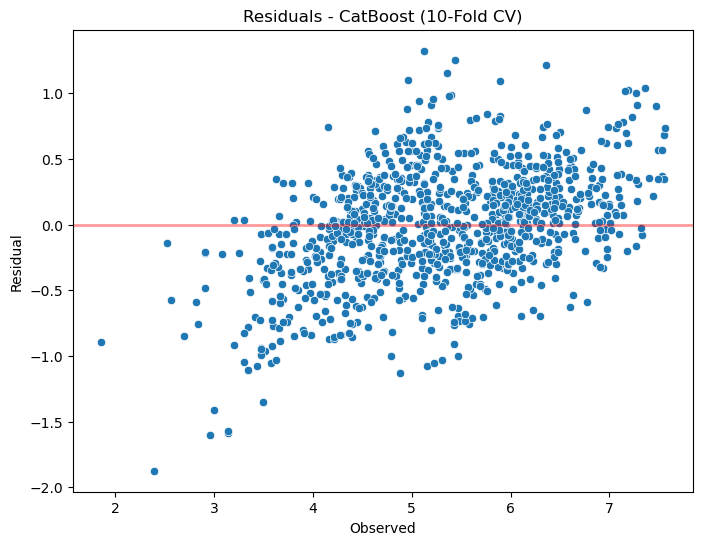

In [19]:
# RESIDUAL PLOT CATBOOST
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_train_cb, y=residuals_cb)
plt.axhline(0, color='red', lw=2, alpha=0.4)
plt.xlabel("Observed")
plt.ylabel("Residual")
plt.title("Residuals - CatBoost (10-Fold CV)")
plt.show()

In [20]:
# FINAL PREDICTIONS DATAFRAME

df_final = pd.DataFrame({
    "happiness_score_real": y_test_cb.values,
    "happiness_score_pred": cat_model.predict(X_test_cb)
})

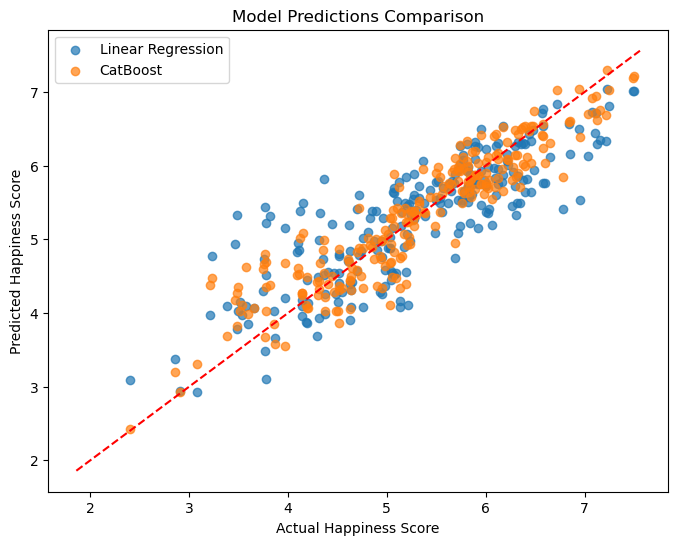

In [21]:
# Compare Linear Regression vs CatBoost visually
plt.figure(figsize=(8,6))
plt.scatter(y_test_lr, linreg_preds, label="Linear Regression", alpha=0.7)
plt.scatter(y_test_cb, cat_model.predict(X_test_cb), label="CatBoost", alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Happiness Score")
plt.ylabel("Predicted Happiness Score")
plt.title("Model Predictions Comparison")
plt.legend()
plt.show()

| Model              | R² Score | RMSE  | 10-Fold CV R² |
| ------------------ | -------- | ----- | ------------- |
| Linear Regression  | 0.701    | 0.552 | 0.712 ± 0.037 |
| CatBoost Regressor | 0.858    | 0.380 | 0.824         |


CatBoost is the best model because it has a higher R², lower RMSE, and better 10-fold cross-validation score than Linear Regression.This happed because catboost can handle the categorical dat i droped for linear

In [22]:
# Save the trained CatBoost model
dump(cat_model, "final_model.pkl")
print("CatBoost model saved as 'final_model.pkl'.")

CatBoost model saved as 'final_model.pkl'.


In [23]:
df_final

,happiness_score_real,happiness_score_pred
0,4.4900,4.027253
1,4.4040,4.387419
2,7.0390,6.704995
3,3.3800,3.693321
4,4.3740,4.219335
...,...,...
236,5.6200,5.689583
237,5.9480,5.751172
238,6.4009,6.534591
239,6.0230,5.692747
